In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import tensorflow as tf
import matplotlib.pyplot as plt

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:")
    for gpu in gpus:
        print(f" - {gpu.name}")
else:
    print("No GPUs available.")

num_skipped = 0
directory = "archive (2)"
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(directory,"PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

No GPUs available.
Deleted 0 images.


In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "archive (2)/PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


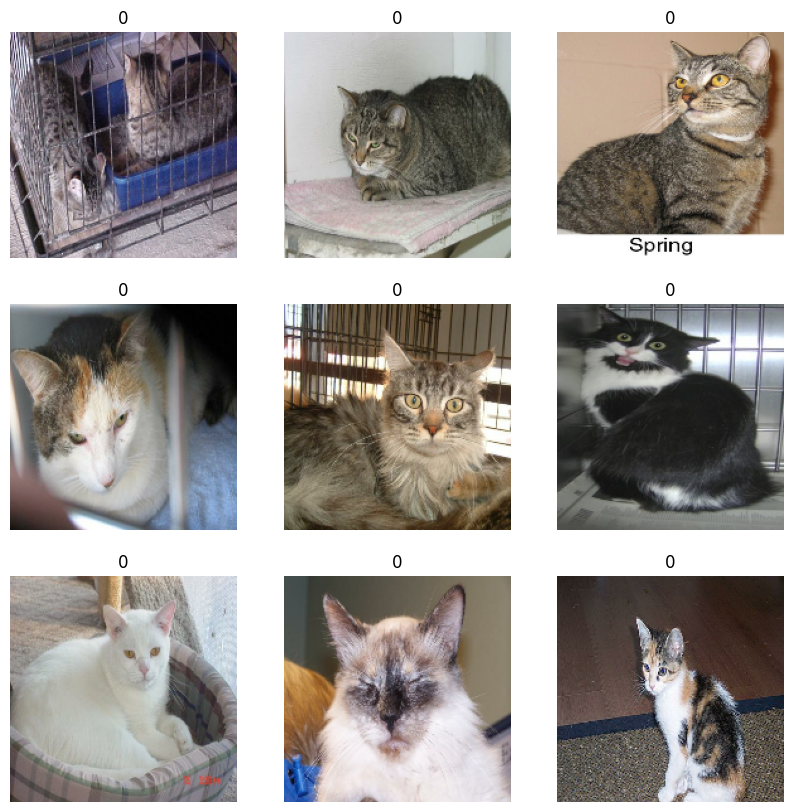

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
from tensorflow.keras import layers

data_augmentation_layers = [
   layers.RandomFlip("horizontal"),  # Horizontal  flips
    layers.RandomRotation(0.1),  # Random rotations by up to 10%
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),  # Random zooming
    layers.RandomContrast(factor=0.2),  # Adjust contrast by a random factor
    layers.RandomBrightness(factor=0.2),  # Adjust brightness by a random factor
    layers.RandomCrop(height=180, width=180),  # Randomly crop the image to a smaller size
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Random translations
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


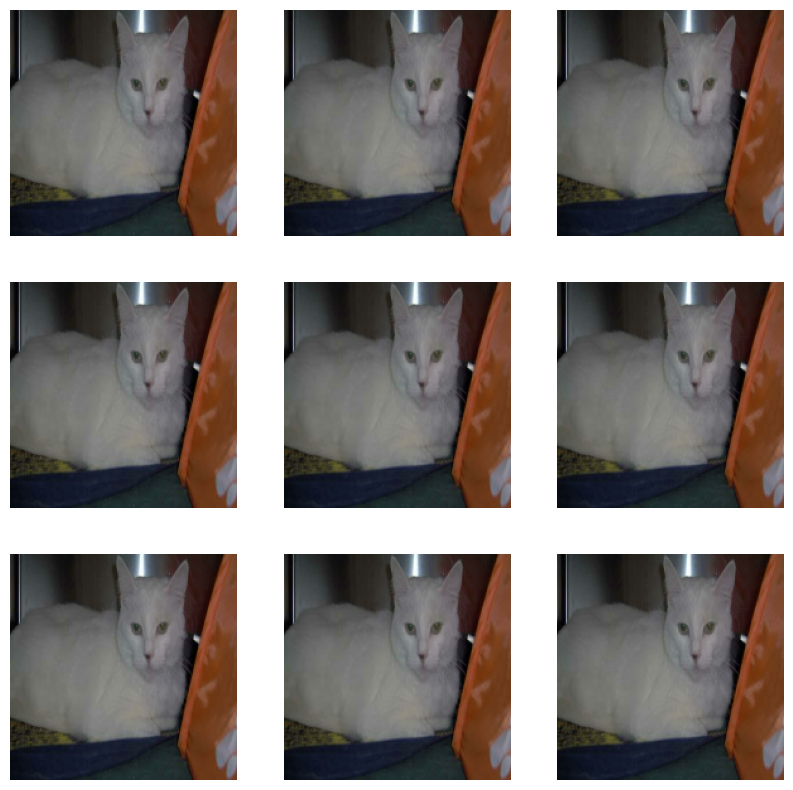

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)


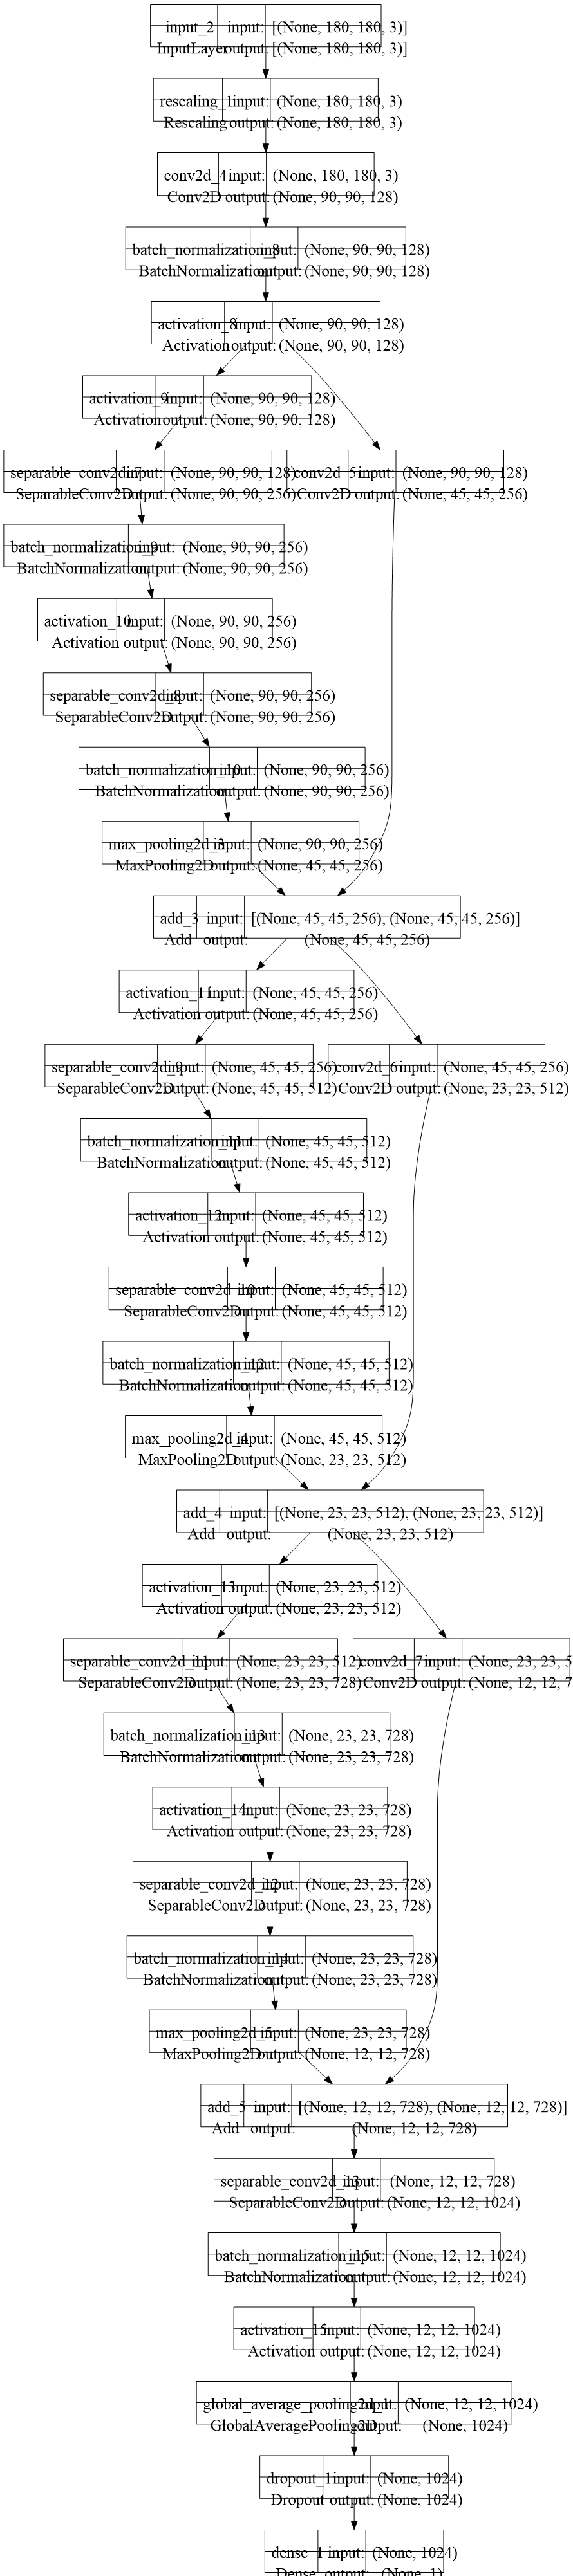

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25


confusion matrix


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model = tf.keras.models.load_model("save_at_29.keras")
# Assuming you have a validation dataset named `val_ds`
val_images, val_labels = [], []

for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Predict probabilities and then convert them to binary predictions
predictions = model.predict(val_images)
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

percision and recalls


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model("save_at_29.keras")

# Generate predictions on validation dataset
val_images, val_labels = [], []

for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Predict probabilities and then convert them to binary predictions
predictions = model.predict(val_images)
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Calculate Precision & Recall
precision = precision_score(val_labels, predicted_labels)
recall = recall_score(val_labels, predicted_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
